# Blockade Subspace Optimizations

## Blockade Mechanism Recap

the Rydberg Blockade phenomena is where two neutral atoms, when close enough together and driven to transition from the ground state $| g \rangle$ to the Rydberg state $| r \rangle$ end up making the state $| rr \rangle$ exceedingly improbable to reach due to an energy shift from a van der Waals interaction.

To really see this in action, recall the many-body Rydberg Hamiltonian:

$$
\frac{\mathcal{H}(t)}{\hbar} = \sum_j \frac{\Omega_j(t)}{2} \left( e^{i \phi_j(t) } | 0_j \rangle  \langle 1_j | + e^{-i \phi_j(t) } | 1_j \rangle  \langle 0_j | \right) - \sum_j \Delta_j(t) \hat{n}_j + \sum_{j < k} V_{jk} \hat{n}_j \hat{n}_k,
$$

The last term describes the van der Waals interaction with the coefficient expanded below:

$$V_{jk} = \frac{C_6}{|\mathbf{x}_j - \mathbf{x}_k|^6}$$

Where $n_j$ is the number operator defined as $| r \rangle \langle r |$ which is $1$ when the atom at the $j$-th or $k$-th site is in the Rydberg state and $0$ otherwise. 

When we have two atoms that are in the Rydberg state, the coefficient gets applied where $C^6$ is the interaction strength, defined as $2\pi\times 862690 \text{ MHz μm}^6$ and the denominator calculates the distance between the atoms.

## Optimizing for Simulation

In a standard simulation of a large number of neutral atoms, the entire state space is accounted in both the statevector as well as the Hamiltonian matrix. 

For example, if I have a system of 10 atoms that means the statevector can have $2^{10} = 1024$ complex entries and the Hamiltonian matrix will have $2^{10} \times 2^{10} = 1048576$ (many of the entries in this matrix will be all zeros, perfectly suited for sparse matrix formats but this is just a back-of-the-envelope calculated upper-bound). It is quite apparent then we fall prey to the exponential growth in computational resources that has come to be the biggest challenge in simulating large quantum systems.

However, we can expand the system sizes we're capable of simulating if we take into account the fact that if we know atoms are close enough to blockade eachother, there is *no need to include that state in the state space!*. Essentially we can operate in a **Blockade Subspace** which leads to smaller state vectors and Hamiltonian matrices.

Bloqade lets you take advantage of this with just a slight modification to any existing problem workflow.

## Taking Advantage of Subspace

Let's start with defining a simple adiabatic sweep on a $3 \times 3$ square lattice of atoms. We place them 6.7 $\mu\text{m}$ apart:

In [11]:
using Bloqade 

atoms = generate_sites(SquareLattice(), 3, 3, scale = 6.7);

and randomly picking a Rabi Frequency of $2.5 \times 2\pi \text{ MHz}$, we calculate the Rydberg blockade will be:

$$\sqrt[6]{\frac{C_6}{\Omega}} = \sqrt[6]{\frac{2\pi\times 862690 \text{ MHz μm}^6}{ 2\pi \times 2.5 \text{ MHz}}} \approx 8.43 \mu\text{m}$$

We can visualize which atoms will blockade each other using Bloqade's plotting function:

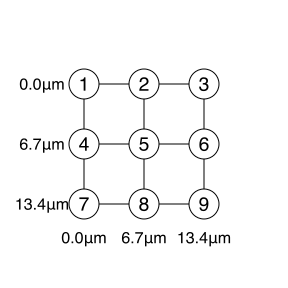

In [12]:
Bloqade.plot(atoms, blockade_radius=8.43)

While we could tell Bloqade to calculate the subspace states by providing this number it's generally advised to **not** do this as throwing away states close to the blockade radius could leave out interactions with significant enough impact on simulation. We recommend setting your subspace radius ($R_s$) to be *less* than the Blockade Radius.

Fortunately in the example we've created the atoms are already close enough that they are covered by the predicted Rydberg blockade radius with room to spare so we can just use 6.7 $\mu\text{m}$ in generating the blockade subspace.

We'll use the `blockade_subspace` function to generate a `Subspace` object that can then be used in conjunction with other functions you've already seen to work in the Blockade subspace.

In [13]:
space = blockade_subspace(atoms, 6.7)

9-qubits 63-elements Subspace{Int64, Vector{Int64}}:
───┬────
  1│ 0
  2│ 1
  3│ 2
   ⋮│ ⋮
 61│ 337
 62│ 340
 63│ 341

Note how if we had not opted for the subspace, we'd have to account for $2^{9} = 512$ states whereas with some knowledge of the blockade radius we can cut that down to $63$ states!

With the `Subspace` we can go ahead and generate a register:

In [14]:
subspace_reg = zero_state(space)

SubspaceArrayReg{2, ComplexF64, Vector{ComplexF64}, Subspace{Int64, Vector{Int64}}}(9, ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], Subspace{Int64, Vector{Int64}}(9, Dict(5 => 5, 268 => 50, 325 => 59, 32 => 13, 136 => 35, 272 => 51, 320 => 55, 337 => 61, 64 => 18, 324 => 58…), [0, 1, 2, 4, 5, 8, 10, 12, 16, 17  …  277, 320, 321, 322, 324, 325, 336, 337, 340, 341]))

Building the rest of your problem is exactly the same as what you'd do without accounting for the blockade subspace.

You'll still define your waveforms just as before:

In [15]:
Ω_max = 2π * 2.5

Δ_val = 2π * 10.0

total_time = 3.0
time_ramp  = total_time * 0.083

clocks = [0, time_ramp, total_time - time_ramp, total_time]

Ω = piecewise_linear(clocks = clocks, values = [0.0, Ω_max, Ω_max, 0.0]); 
Δ = piecewise_linear(clocks = clocks, values = [-Δ_val, -Δ_val, Δ_val, Δ_val]);
ϕ = constant(;duration = total_time, value = 0.0);

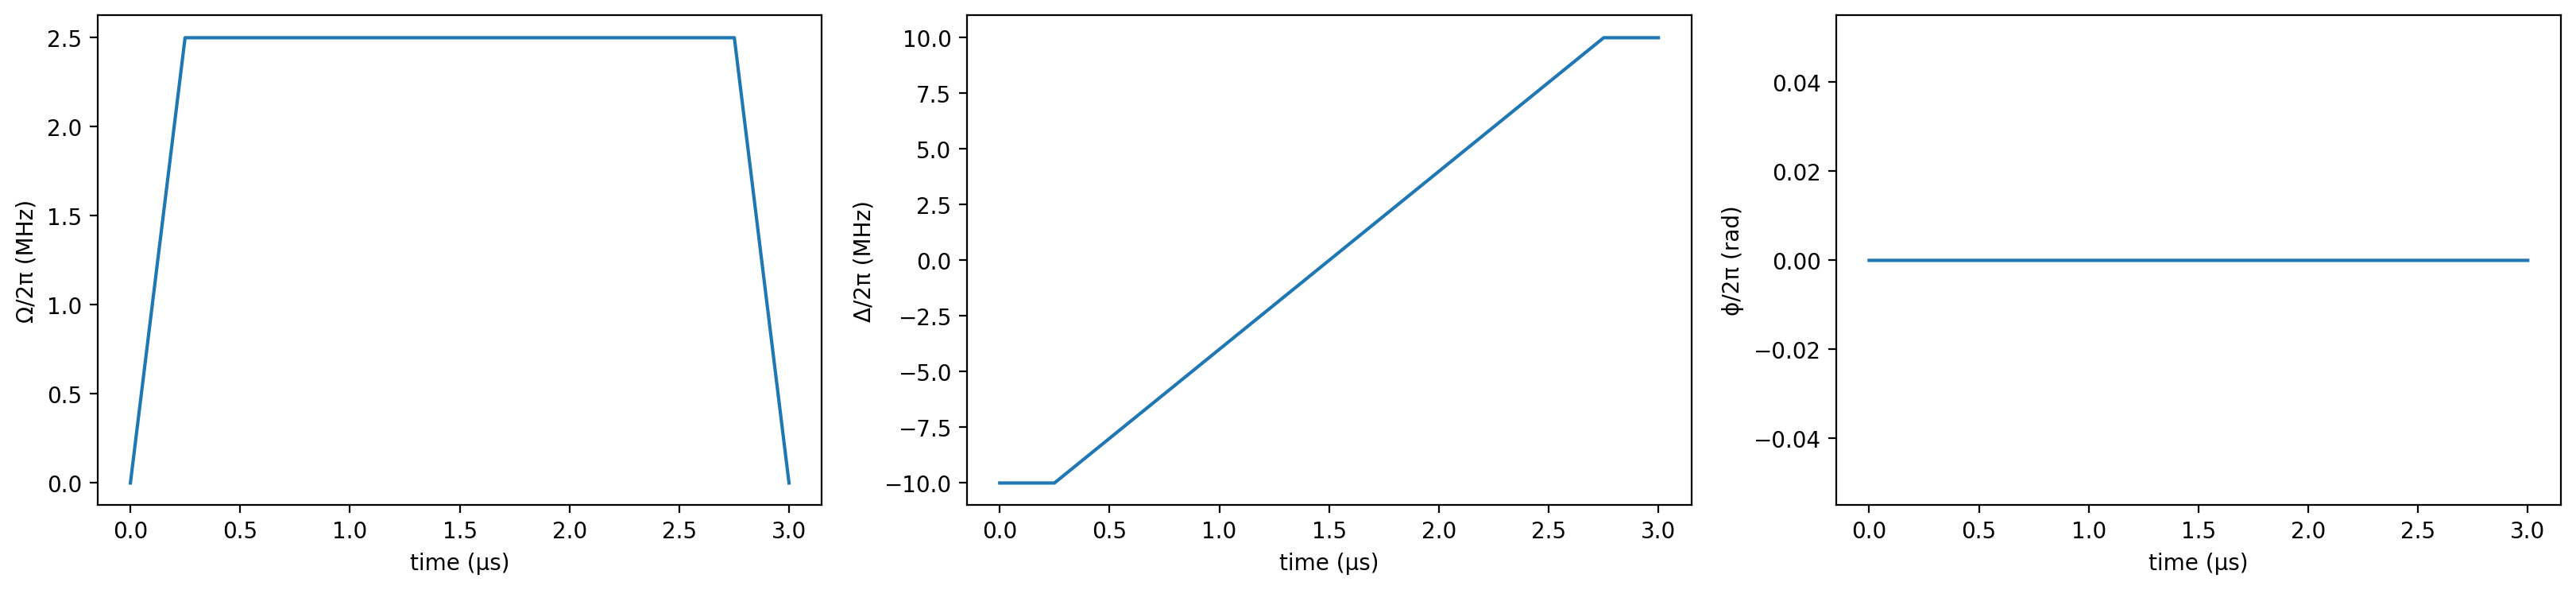

In [16]:
using PythonCall
plt = pyimport("matplotlib.pyplot");

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (20, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
Bloqade.plot!(ax3, ϕ)
ax3.set_ylabel("ϕ/2π (rad)")
fig

Generate the Rydberg Hamiltonian and the associated `SchrodingerProblem` that gets used for emulation:

In [17]:
h = rydberg_h(atoms; Ω=Ω, Δ=Δ, ϕ=ϕ);
prob = SchrodingerProblem(subspace_reg, total_time, h)

SchrodingerProblem:
  register info:
    type: SubspaceArrayReg{2, ComplexF64, Vector{ComplexF64}, Subspace{Int64, Vector{Int64}}}
    storage size: 40 bytes

  time span (μs): (0.0, 3.0)

  equation: 
    storage size: 11.820 KiB
    expression:
nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: CompositeAlgorithm{Tuple{Vern9{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Rodas5{0, false, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}}, AutoSwitch{Vern9{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Rodas5{0, false, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}((Vern9(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true), Rodas5{0, false, Nothing, t

And feed it into `emulate!`:

In [ ]:
emulate!(prob);

One difference after performing simulation is to get the raw statevector you'll need to use the `statevec` function on the register:

In [21]:
statevec(prob.reg)

63-element Vector{ComplexF64}:
    8.55873929440454e-7 + 7.802751079325715e-7im
   9.008705879484976e-6 - 1.2130793530021016e-5im
  -7.383301676813542e-7 - 1.5834612354261676e-5im
   9.008705879476988e-6 - 1.2130793530048078e-5im
  -7.395376257003491e-5 - 0.0015533411458065708im
  -7.383301676334292e-7 - 1.5834612354262655e-5im
 -0.0003381432546603138 - 0.00010947400566925066im
 -0.0002981948434137196 - 0.0007202504549030106im
   4.429557711693752e-5 + 2.1583767835336555e-5im
 -1.2221028311435916e-5 - 6.734501861202937e-5im
                        ⋮
  -7.395376256999226e-5 - 0.001553341145806432im
  -0.030147944482009643 + 0.003869669732031274im
   -0.06545650206865872 - 0.00448056942321221im
   -0.03014794448200977 + 0.003869669732031482im
   0.031370149984532296 - 0.10683498402639062im
 0.00032677768374523837 + 0.0024655106760160697im
  -0.023457162412098418 + 0.12389919451661104im
   -0.02345716241209894 + 0.12389919451661073im
    -0.9133642394876488 - 0.19796848204169845im

Note how analysis remains consistent as before:

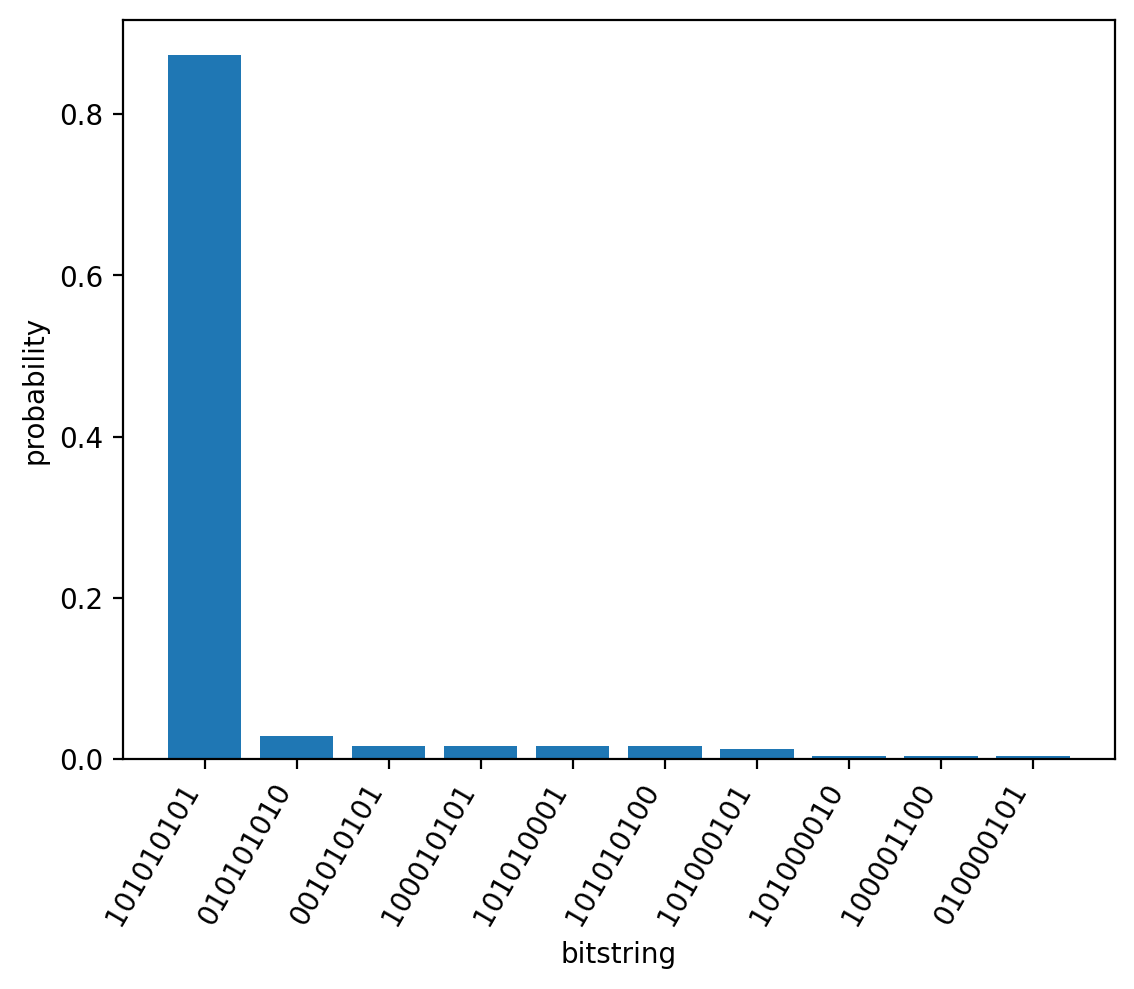

In [22]:
bitstring_hist(prob.reg; nlargest = 10)

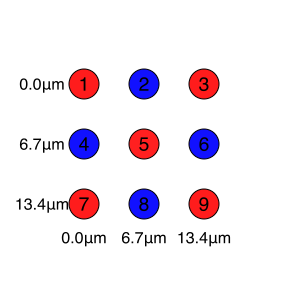

In [20]:
plot_densities(atoms, rydberg_density(prob.reg))